# Modified IQAE tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from algorithms import NoQuantumIterativeAmplitudeEstimation
from operators import *

In [2]:
# for setting a single amplitude, below automates this for arbirtrary numbers of amplitudes
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def make_problems(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    problem2 = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem, problem2

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 128

## Compare Modified IQAE to No-Quantum IQAE

In [5]:
# parameters for IQAE

# amplitudes
n = 4
k = 2**n

# epsilons
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]

# other
alpha = 0.05
confint_method = 'chernoff'
verbose = False

a: 0/16 = 0.0
Modified IAE estimations: [0.00015914946148561397, 7.959852195178624e-07, 5.392432722926827e-09, 7.248228030976605e-11, 3.5479165626833963e-13]
Fixed Original IAE estimations: [0.0001708664274156844, 9.865249172817861e-07, 6.663619444287578e-09, 5.7065764415064465e-11, 4.2021269411237273e-13]
Modified IAE total queries: 82484992
Fixed Original IAE total queries: 91604096
Modified IAE epsilons: [0.00015914946148561397, 7.959852195178624e-07, 5.392432722926827e-09, 7.248228030976605e-11, 3.5479165626833963e-13]
Fixed Original IAE epsilons: [0.0001708664274156844, 9.865249172817861e-07, 6.663619444287578e-09, 5.7065764415064465e-11, 4.2021269411237273e-13]
Modified wins? False with 11.06% difference


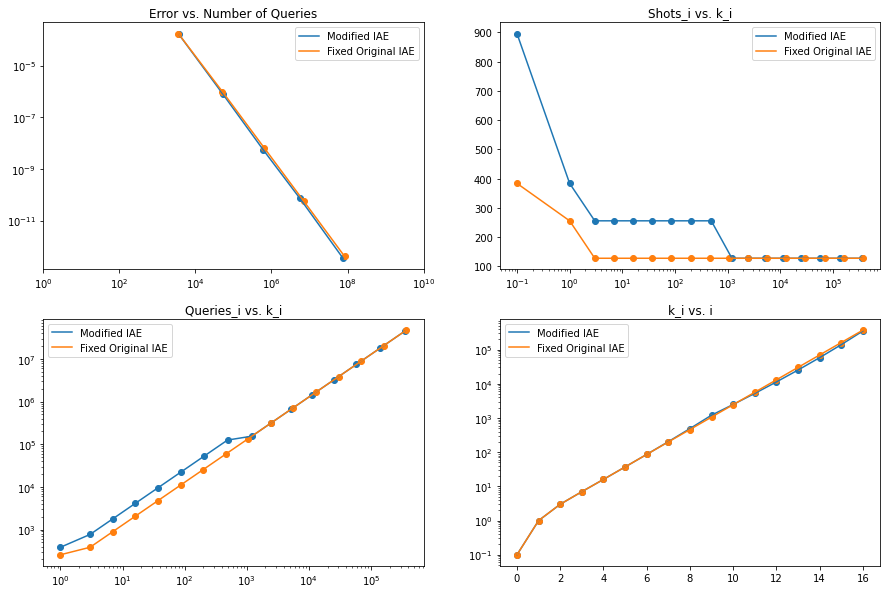

a: 1/16 = 0.0625
Modified IAE estimations: [0.0627438423477471, 0.06257885622546402, 0.062497511142938236, 0.06249909157017884, 0.06250000234263324]
Fixed Original IAE estimations: [0.0630401373009373, 0.06242562544584006, 0.06250351980064324, 0.06250050052114917, 0.06250010985745112]
Modified IAE total queries: 114866432
Fixed Original IAE total queries: 106284160
Modified IAE epsilons: [0.0032954919601197383, 0.0004070297543551267, 3.886167652379646e-05, 2.756910812837937e-06, 2.0483521264227922e-07]
Fixed Original IAE epsilons: [0.0038162992879186217, 0.0004193418489226615, 3.884327634355242e-05, 3.4571087413858004e-06, 3.8775880618902026e-07]
Modified wins? True with 7.47% difference


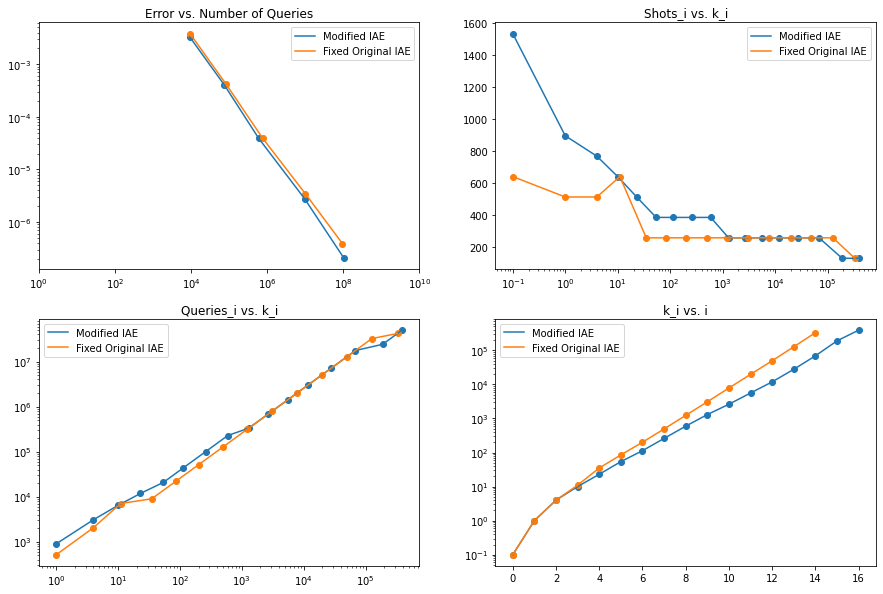

a: 2/16 = 0.125
Modified IAE estimations: [0.12424907040643533, 0.12499838002439402, 0.12500644979843437, 0.12499988705016446, 0.12500006679038536]
Fixed Original IAE estimations: [0.12511096350493067, 0.12489082509769914, 0.12499525467968588, 0.12499911179825848, 0.12499986405781822]
Modified IAE total queries: 88022144
Fixed Original IAE total queries: 107713408
Modified IAE epsilons: [0.005198685114288351, 0.0003947886186904531, 3.83077785336694e-05, 4.767371589879665e-06, 4.4033981586727444e-07]
Fixed Original IAE epsilons: [0.004831199374941544, 0.0005532125886771669, 5.015464431142036e-05, 5.045806105684336e-06, 5.310926788210102e-07]
Modified wins? False with 22.37% difference


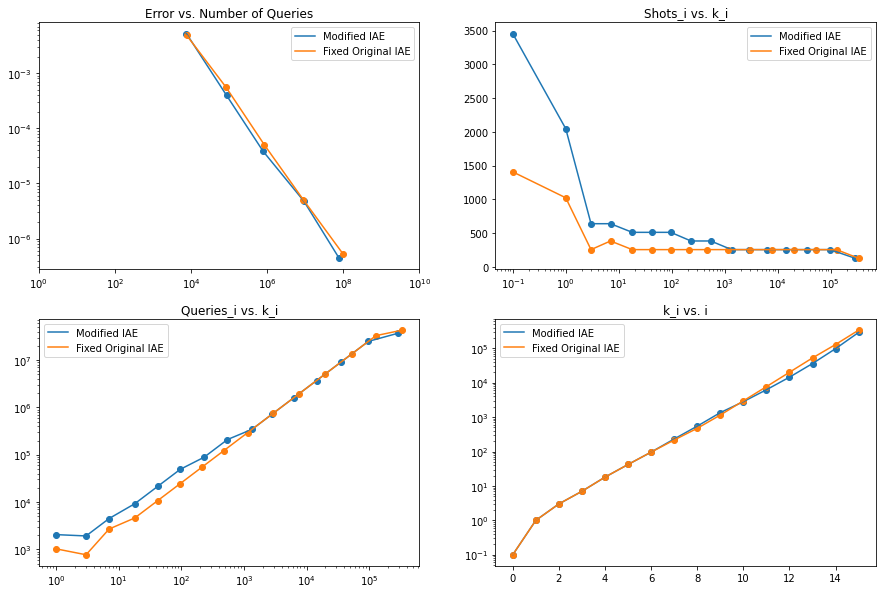

a: 3/16 = 0.1875
Modified IAE estimations: [0.18711604894497366, 0.18757974262665145, 0.1875097272871618, 0.1875000240536233, 0.18750006459433577]
Fixed Original IAE estimations: [0.18727816787299592, 0.1875198866809303, 0.187493808261961, 0.1874990785008387, 0.18417155588107972]
Modified IAE total queries: 91905792
Fixed Original IAE total queries: 92680448
Modified IAE epsilons: [0.006365290964429532, 0.0007506730159184266, 5.401529454675258e-05, 6.584568716383465e-06, 4.347605565974133e-07]
Fixed Original IAE epsilons: [0.00625771059186056, 0.0007199058320901397, 6.269942538260354e-05, 5.5861746688368186e-06, 5.341060761443472e-07]
Modified wins? False with 0.84% difference


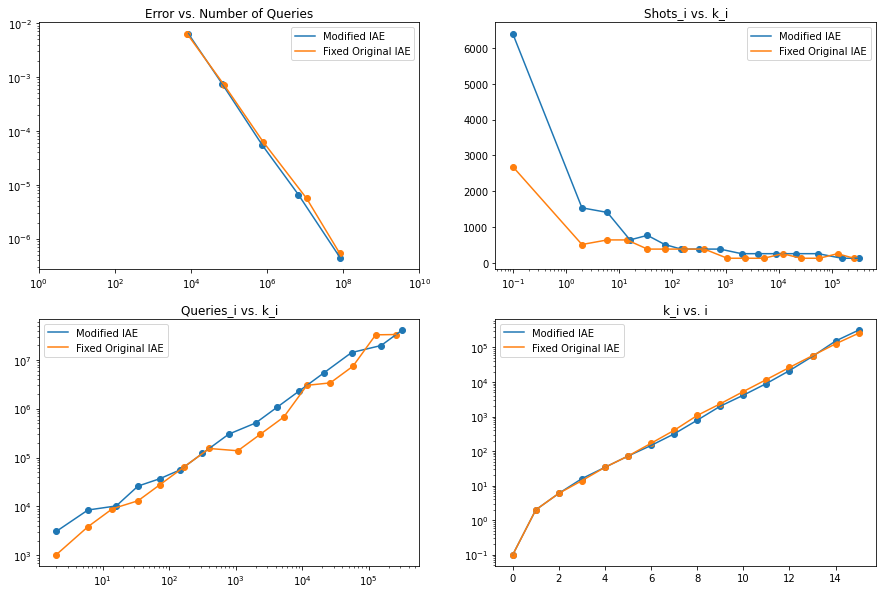

a: 4/16 = 0.25
Modified IAE estimations: [0.2508486605066259, 0.2500071978509867, 0.25000404460548475, 0.2500025245456859, 0.2499998268983737]
Fixed Original IAE estimations: [0.2526160896635127, 0.2498863865870033, 0.25001226397754495, 0.2499989886720312, 0.25000008192546264]
Modified IAE total queries: 132940672
Fixed Original IAE total queries: 161300352
Modified IAE epsilons: [0.006478459911782031, 0.0007376534167345267, 5.5176289692829283e-05, 8.226138088499035e-06, 5.998840107018788e-07]
Fixed Original IAE epsilons: [0.008660981011205715, 0.0006928694393934925, 6.496004613133766e-05, 7.327319675370925e-06, 6.213999246829083e-07]
Modified wins? False with 21.33% difference


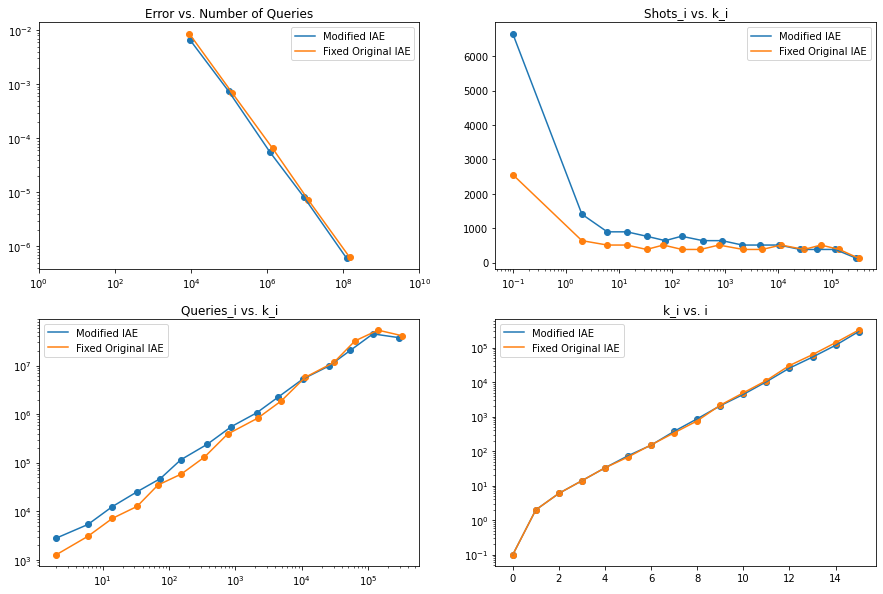

a: 5/16 = 0.3125
Modified IAE estimations: [0.31169278931774286, 0.3125644640192436, 0.3125048154378379, 0.3125001736905879, 0.31250005577026696]
Fixed Original IAE estimations: [0.31186448435854885, 0.31250189021685765, 0.3124801095388917, 0.3125014300269773, 0.31250010950325857]
Modified IAE total queries: 81222016
Fixed Original IAE total queries: 83261056
Modified IAE epsilons: [0.005744321145630449, 0.0009151032679622917, 8.817399433005968e-05, 5.592191137937519e-06, 6.033845053876608e-07]
Fixed Original IAE epsilons: [0.006612624858542193, 0.0006303555757233292, 8.840641356444578e-05, 6.560752096568256e-06, 8.022920324202154e-07]
Modified wins? False with 2.51% difference


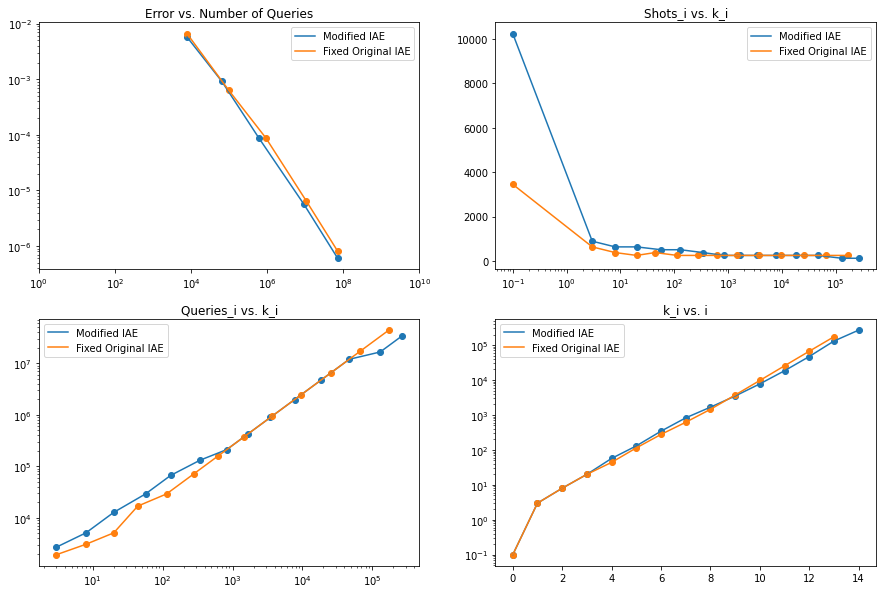

a: 6/16 = 0.375
Modified IAE estimations: [0.3766811778106187, 0.37498665428423683, 0.3750124783754829, 0.37500160964654905, 0.37499998667171747]
Fixed Original IAE estimations: [0.37728645873731304, 0.3750608520961476, 0.3750001575273162, 0.37500202342180855, 0.37500006349065274]
Modified IAE total queries: 107121664
Fixed Original IAE total queries: 80794624
Modified IAE epsilons: [0.006073127404176287, 0.0009050589305991952, 4.490948301105746e-05, 8.321182909415414e-06, 4.4612706762148235e-07]
Fixed Original IAE epsilons: [0.00786967019678908, 0.0007886352749988668, 6.588288001641018e-05, 8.282547357407744e-06, 8.460836584123221e-07]
Modified wins? True with 24.58% difference


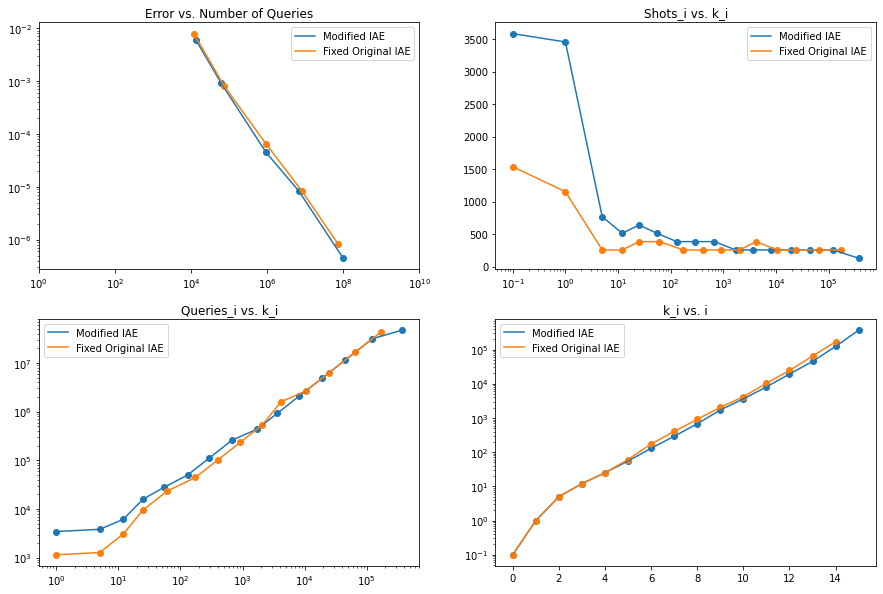

a: 7/16 = 0.4375
Modified IAE estimations: [0.4372693616767922, 0.43741933229976093, 0.4375051747890191, 0.43749988950834573, 0.437499845162198]
Fixed Original IAE estimations: [0.4359946638037776, 0.43750070726276125, 0.4375064075268233, 0.4374980953991199, 0.4375001551450489]
Modified IAE total queries: 85375616
Fixed Original IAE total queries: 109488256
Modified IAE epsilons: [0.00733824281072995, 0.0009383059684468509, 8.773790696070538e-05, 9.14822795058945e-06, 6.665509337533404e-07]
Fixed Original IAE epsilons: [0.0082890057674401, 0.0009546774625440457, 6.604463170628572e-05, 6.917077467832877e-06, 8.819816826877158e-07]
Modified wins? False with 28.24% difference


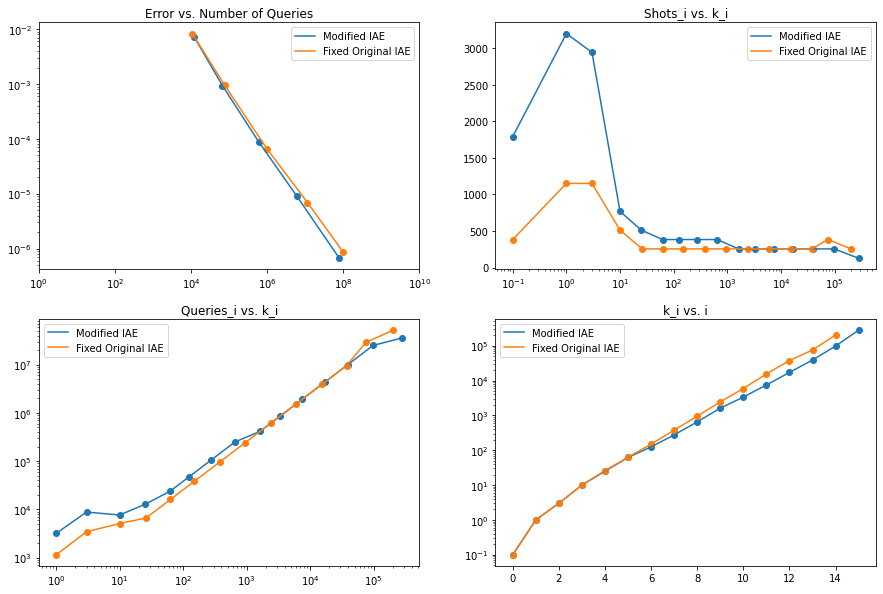

a: 8/16 = 0.5
Modified IAE estimations: [0.4993618636063817, 0.5, 0.5000040828838903, 0.4999986948418762, 0.5000000548437523]
Fixed Original IAE estimations: [0.49920384015334773, 0.5000566942945796, 0.4999949920993702, 0.49999686506905217, 0.50000004856023]
Modified IAE total queries: 65672704
Fixed Original IAE total queries: 86249600
Modified IAE epsilons: [0.007375198755597584, 0.00044277343169540906, 7.461838039332647e-05, 8.304215088905664e-06, 9.528889028942444e-07]
Fixed Original IAE epsilons: [0.009489700780236338, 0.0006779322436528956, 7.710539231037261e-05, 9.883975032293213e-06, 8.666137750468206e-07]
Modified wins? False with 31.33% difference


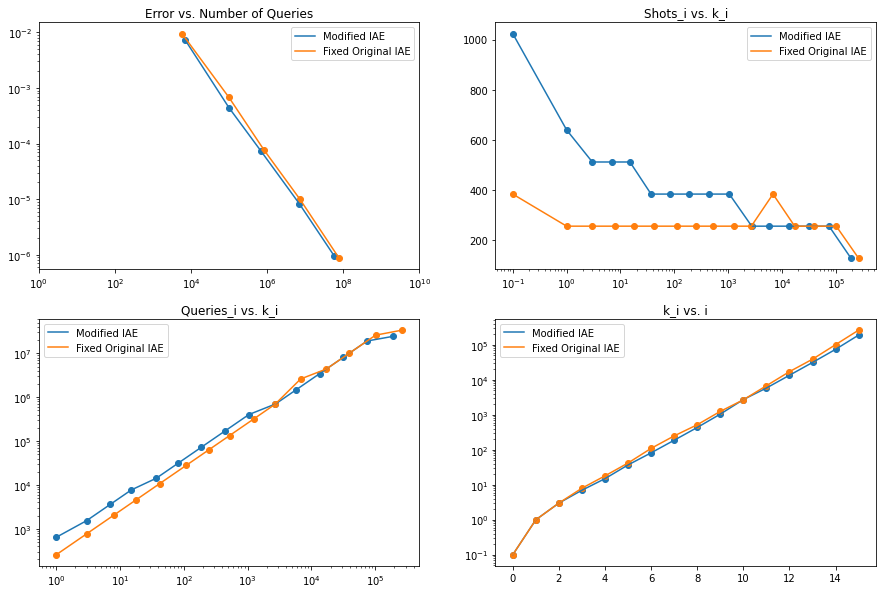

a: 9/16 = 0.5625
Modified IAE estimations: [0.5619965114945613, 0.5625265443117233, 0.5581240024723708, 0.5581965680981837, 0.5624999325251283]
Fixed Original IAE estimations: [0.5647953650940709, 0.5624970233391493, 0.5625170354110304, 0.5625014158660315, 0.5624897206737709]
Modified IAE total queries: 105838080
Fixed Original IAE total queries: 98265984
Modified IAE epsilons: [0.007467138008523, 0.0006955404177624858, 9.886807038589351e-05, 7.0654150762794465e-06, 4.901895472864126e-07]
Fixed Original IAE epsilons: [0.009027916907169697, 0.0008584792734853686, 6.82712306792066e-05, 8.101172762120523e-06, 9.70166011526885e-07]
Modified wins? True with 7.15% difference


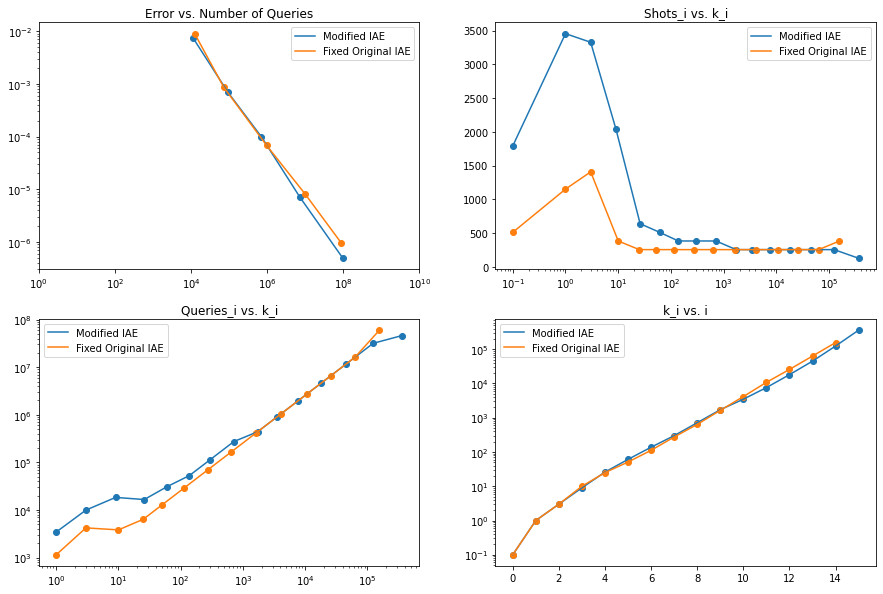

a: 10/16 = 0.625
Modified IAE estimations: [0.62605605206741, 0.6250720156288121, 0.6031964838870643, 0.6249986811629671, 0.6250001610292777]
Fixed Original IAE estimations: [0.6234866320291497, 0.6004123786569592, 0.6011261634692557, 0.6019863703414412, 0.6250003286436159]
Modified IAE total queries: 66156416
Fixed Original IAE total queries: 97229952
Modified IAE epsilons: [0.005778690914367557, 0.0007706435434930436, 6.498803174220802e-05, 7.246016388962051e-06, 9.626495995340711e-07]
Fixed Original IAE epsilons: [0.006240937243944811, 0.0009585607774684757, 9.580071118309164e-05, 5.00993749996681e-06, 9.254672599934288e-07]
Modified wins? False with 46.97% difference


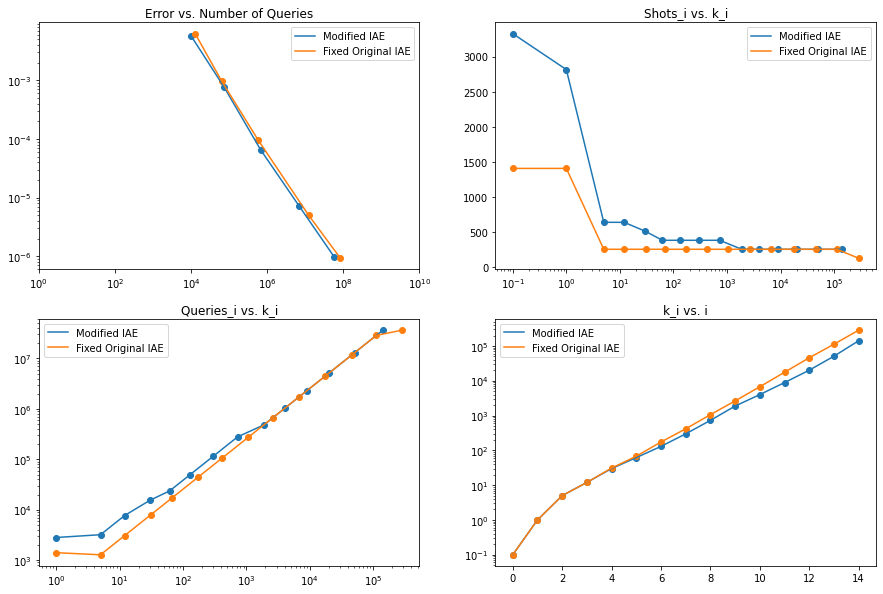

a: 11/16 = 0.6875
Modified IAE estimations: [0.6884027544465101, 0.687521416117413, 0.6875010005575997, 0.6874340902415098, 0.6875000574039025]
Fixed Original IAE estimations: [0.6860663920014052, 0.6874383458758304, 0.6875083266096056, 0.6872612017117541, 0.6874999896641343]
Modified IAE total queries: 104228992
Fixed Original IAE total queries: 90975744
Modified IAE epsilons: [0.006844293516256317, 0.0005227527843706947, 6.994965728512881e-05, 5.704519465687952e-06, 4.5382103447400013e-07]
Fixed Original IAE epsilons: [0.006127620518544263, 0.0007631292121029754, 7.472890357046458e-05, 5.676953217848002e-06, 7.47623588537305e-07]
Modified wins? True with 12.72% difference


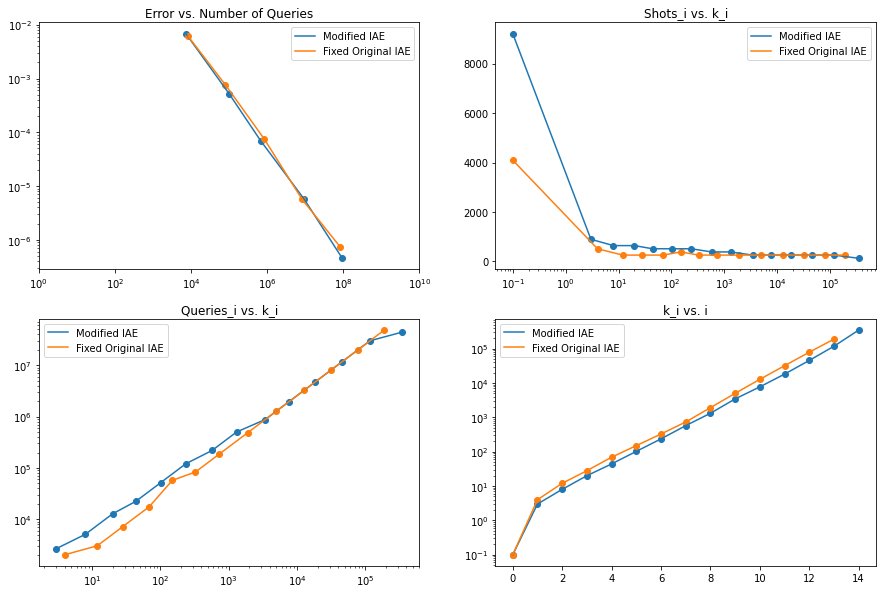

a: 12/16 = 0.75
Modified IAE estimations: [0.7502989486237026, 0.7499589330987475, 0.7500145297972025, 0.7499969503929033, 0.7500001743322307]
Fixed Original IAE estimations: [0.7504142892149959, 0.7503310319996093, 0.7499923552626048, 0.7499968561946633, 0.7499998364770453]
Modified IAE total queries: 111385728
Fixed Original IAE total queries: 126874752
Modified IAE epsilons: [0.007108592129333624, 0.0008491789662811722, 6.600468293277428e-05, 8.165322076481019e-06, 8.042478507608308e-07]
Fixed Original IAE epsilons: [0.007621238851109158, 0.0008527739187004779, 7.928209662177998e-05, 7.012804463746303e-06, 7.997616479626934e-07]
Modified wins? False with 13.91% difference


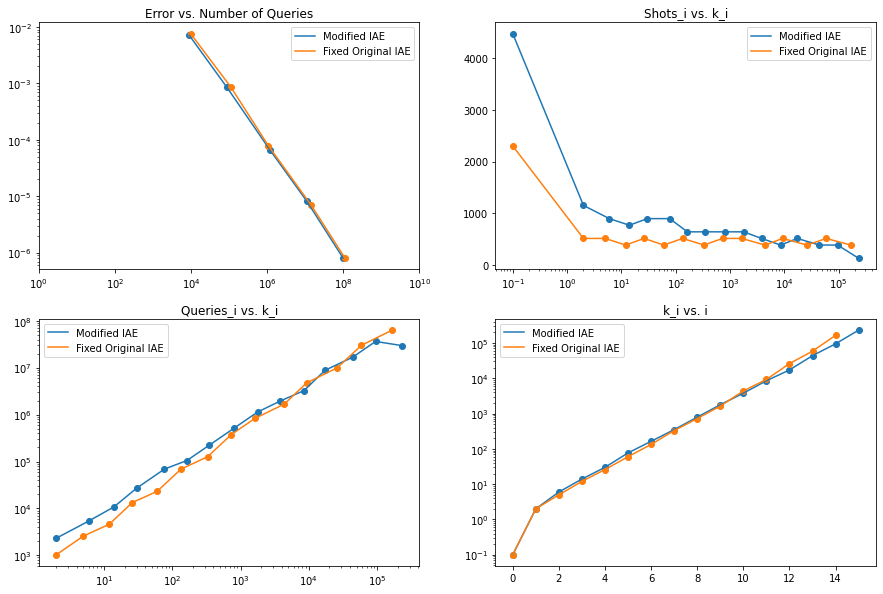

a: 13/16 = 0.8125
Modified IAE estimations: [0.8119727747370641, 0.8126364035106521, 0.8125077554779039, 0.8125007964771394, 0.8124998845502227]
Fixed Original IAE estimations: [0.8139444842594314, 0.812343000594761, 0.8124996027530912, 0.8124988452858379, 0.8125000482246467]
Modified IAE total queries: 66053760
Fixed Original IAE total queries: 101662080
Modified IAE epsilons: [0.005618852626517068, 0.0004645919983018998, 7.725318677503923e-05, 7.218995406677031e-06, 7.525143979614235e-07]
Fixed Original IAE epsilons: [0.006226892209736656, 0.0005980996653942583, 5.98142638043031e-05, 7.080353989552535e-06, 5.615436952655095e-07]
Modified wins? False with 53.91% difference


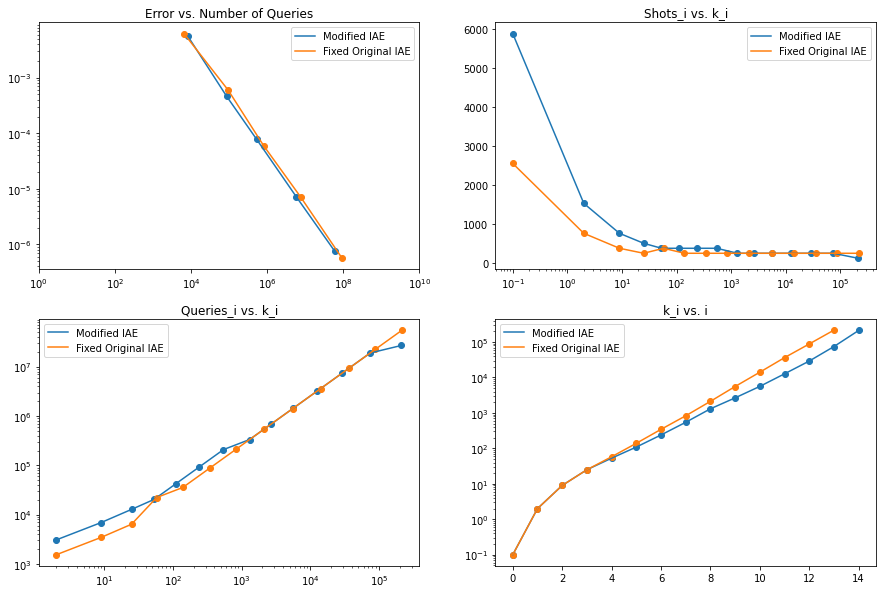

a: 14/16 = 0.875
Modified IAE estimations: [0.8745028941021828, 0.8750484285260653, 0.8749926618492498, 0.8750007320626474, 0.87499998444311]
Fixed Original IAE estimations: [0.8742955186914929, 0.8751262433136402, 0.874991114766919, 0.8750015437550999, 0.8750000566641074]
Modified IAE total queries: 104862976
Fixed Original IAE total queries: 85417600
Modified IAE epsilons: [0.004508994404712474, 0.0003214492886939868, 5.693011417690075e-05, 3.4862798233836756e-06, 3.5451185514956407e-07]
Fixed Original IAE epsilons: [0.005820801508676643, 0.0005495521672405634, 6.528797260274555e-05, 6.164088703797255e-06, 5.415032183764268e-07]
Modified wins? True with 18.54% difference


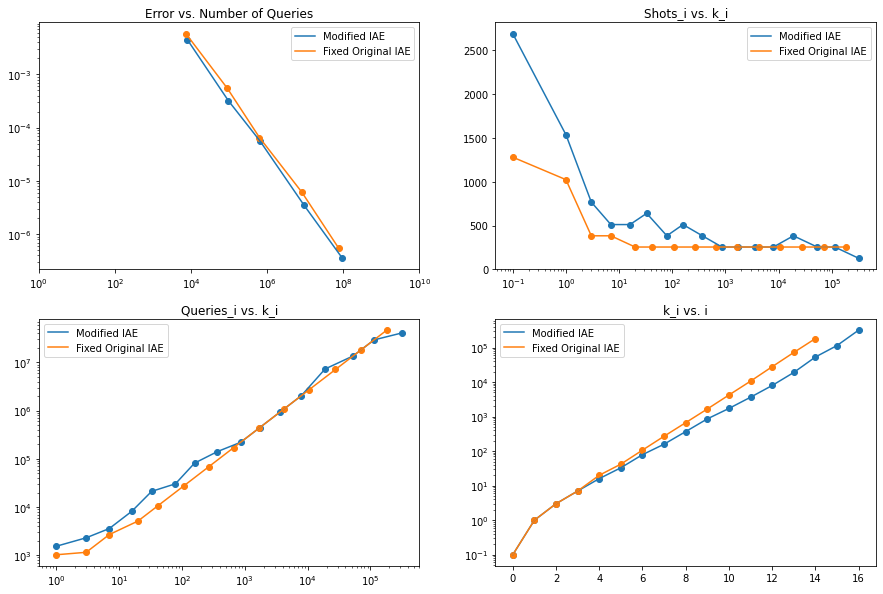

a: 15/16 = 0.9375
Modified IAE estimations: [0.9371583352766493, 0.9375783194375975, 0.9375061698500327, 0.9374996034789722, 0.9374998239413455]
Fixed Original IAE estimations: [0.9368997034263572, 0.9375407260962785, 0.9375212185581365, 0.937499926077779, 0.9375000693902134]
Modified IAE total queries: 91037824
Fixed Original IAE total queries: 122600320
Modified IAE epsilons: [0.003309612446869281, 0.0004308872402783437, 2.197308741230808e-05, 2.6604040758160252e-06, 4.286237473283272e-07]
Fixed Original IAE epsilons: [0.004455233805499725, 0.00047365582930525285, 4.776269227041441e-05, 2.9778442360295365e-06, 2.8102665355911327e-07]
Modified wins? False with 34.67% difference


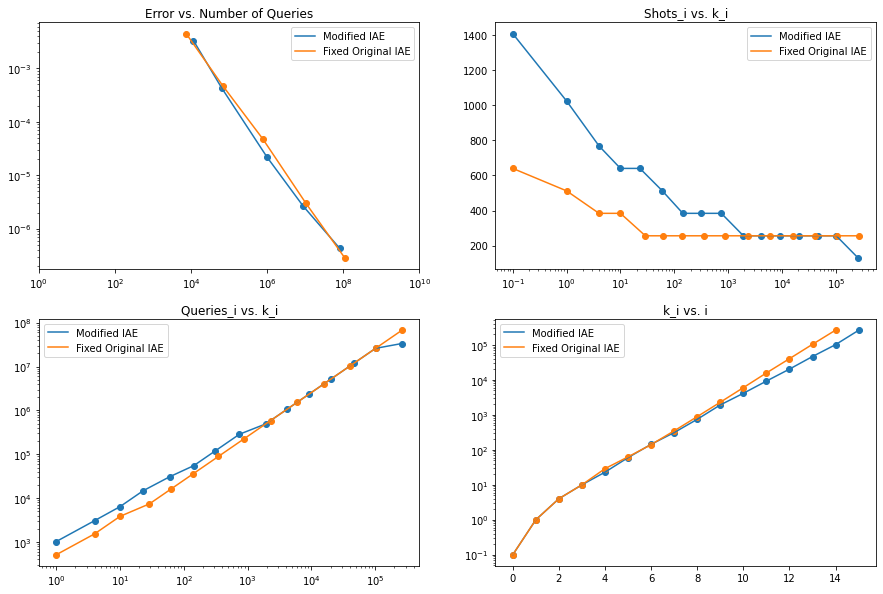

a: 16/16 = 1.0
Modified IAE estimations: [0.9998408505385143, 0.9999992040147805, 0.9999999946075673, 0.9999999999275178, 0.9999999999996452]
Fixed Original IAE estimations: [0.9998291335725844, 0.9999990134750827, 0.9999999933363806, 0.9999999999429342, 0.9999999999995798]
Modified IAE total queries: 82484992
Fixed Original IAE total queries: 91604096
Modified IAE epsilons: [0.00015914946148565257, 7.959852194594497e-07, 5.3924327225729485e-09, 7.24822424302829e-11, 3.5482727867020003e-13]
Fixed Original IAE epsilons: [0.00017086642741565017, 9.865249173124369e-07, 6.663619434021939e-09, 5.7065796532640434e-11, 4.2021941482062175e-13]
Modified wins? False with 11.06% difference


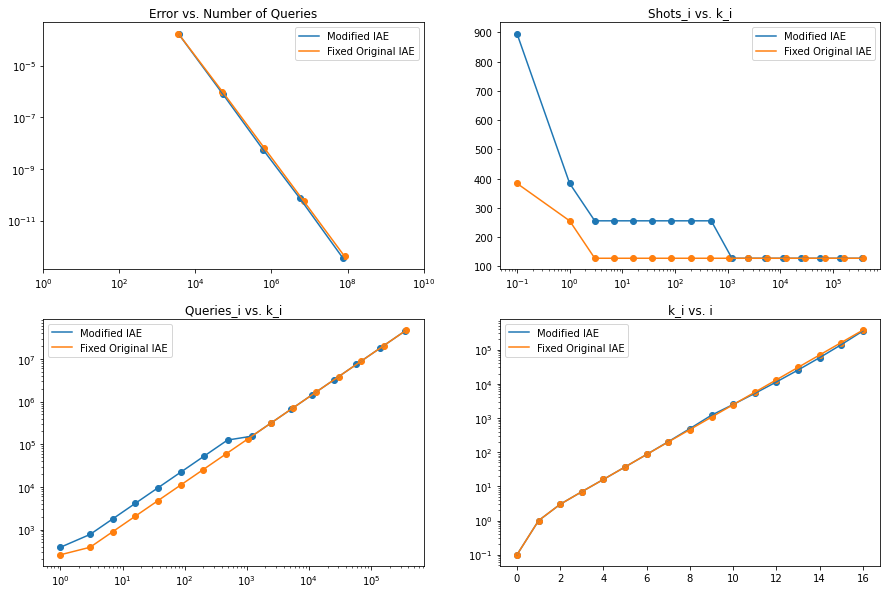

% modified > original: 0.29411764705882354


In [6]:
# stats recording
iae_epsilon = []
iae_nshots = []
miae_epsilon = []
miae_nshots = []

wins = matches = 0

ki = 0
while ki <= k:
    
    # setup problems with specified N,k
    N = 2**n
    marked = sample(range(N), ki)
    problem, problem2 = make_problems(n, marked)
    
    # execute experiments for each power
    miae_results = [] 
    iae_results = []
    
    for i, epsilon in enumerate(epsilons):
        if verbose:
            print('ε:',epsilon)
            
        MIAE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                    alpha=alpha, 
                                                    confint_method=confint_method, 
                                                    quantum_instance=aer_sim)
        
        IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                    alpha=alpha, 
                                                    confint_method=confint_method, 
                                                    quantum_instance=aer_sim)
        
        exprs = ['Modified IAE', 'Fixed Original IAE']
        
        # configure the number of shots this way and pray that it works
        MIAE._quantum_instance._run_config.shots = shots
        IAE._quantum_instance._run_config.shots = shots
        
        # for recording intermediate algo results
        state = defaultdict(dict)
        state2 = defaultdict(dict)
        
        miae_result = MIAE.estimate(problem,
                                    state=state,
                                    verbose=verbose)
        
        iae_result = IAE.estimate(problem2,
                                  state=state2,
#                                   k0=ki,
#                                   N=N,
                                  verbose=verbose)
        
        miae_results.append(miae_result)
        iae_results.append(iae_result)
        if verbose:
            print()
    
    # process results
    miae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results]
    miae_nshots_i  = [res.num_oracle_queries for res in miae_results]

    iae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results]
    iae_nshots_i  = [res.num_oracle_queries for res in iae_results]
    
    print(f'a: {ki}/{N} = {ki/N}')
    print(f'{exprs[0]} estimations:', [res.estimation for res in miae_results])
    print(f'{exprs[1]} estimations:', [res.estimation for res in iae_results])
    
    miae_total_queries, iae_total_queries = sum(miae_nshots_i), sum(iae_nshots_i)
    print(f'{exprs[0]} total queries:', miae_total_queries)
    print(f'{exprs[1]} total queries:', iae_total_queries)
    
    print(f'{exprs[0]} epsilons:', miae_epsilon_i)
    print(f'{exprs[1]} epsilons:', iae_epsilon_i)
    
    diff = round(abs(iae_total_queries - miae_total_queries) / miae_total_queries * 100, 2)
    print('Modified wins?', iae_total_queries < miae_total_queries, f'with {diff}% difference')
    
    wins += int(iae_total_queries < miae_total_queries)
    matches += 1
    
    # graph k_i vs num_shots
    def process_state(state):
        if len(state) == 0: return [],[]
        round_shots = state['round_shots']
        queries = state['n_queries']
        shots_at_k0 = round_shots.pop(0)
        queries_at_k0 = queries.pop(0)
    
        k_i = [k for k in round_shots]
        queries_i = [queries[k] for k in k_i]
        shots_i = [shots_at_k0] + [round_shots[k] for k in k_i]
    
        k_i.insert(0, 0.1)
        
        return shots_i, queries_i, k_i
    
    mod_shots, mod_queries, mod_k = process_state(state)
    base_shots, base_queries, base_k = process_state(state2)

    fig,axs = plt.subplots(2,2,figsize=(15,10))
    
    # plot query complexity
    
    axs[0,0].set_yscale('log')
    axs[0,0].set_xscale('log')
    axs[0,0].set_xlim(1, 10**10)
    axs[0,0].set_title('Error vs. Number of Queries')
    
    axs[0,0].scatter(miae_nshots_i, miae_epsilon_i)
    axs[0,0].plot(miae_nshots_i, miae_epsilon_i)
    axs[0,0].scatter(iae_nshots_i, iae_epsilon_i)
    axs[0,0].plot(iae_nshots_i, iae_epsilon_i)
    
    axs[0,0].legend(exprs)
    
    # plots for shots vs k
    axs[0,1].set_xscale('log')
    axs[0,1].set_title('Shots_i vs. k_i')
    
    axs[0,1].plot(mod_k, mod_shots)
    axs[0,1].scatter(mod_k, mod_shots)
    axs[0,1].plot(base_k, base_shots)
    axs[0,1].scatter(base_k, base_shots)
    
    axs[0,1].legend(exprs)
    
    # plots for nqueries vs k
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('Queries_i vs. k_i')
    
    axs[1,0].plot(mod_k[1:], mod_queries)
    axs[1,0].scatter(mod_k[1:], mod_queries)
    axs[1,0].plot(base_k[1:], base_queries)
    axs[1,0].scatter(base_k[1:], base_queries)
    
    axs[1,0].legend(exprs)
    
    # plots for k
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('k_i vs. i')
    
    axs[1,1].plot(mod_k)
    axs[1,1].scatter(range(len(mod_k)), mod_k)
    axs[1,1].plot(base_k)
    axs[1,1].scatter(range(len(base_k)), base_k)
    
    axs[1,1].legend(exprs)
    
    plt.show()
    
    # save results for epsilon vs nshots
    miae_nshots.append(miae_nshots_i)
    miae_epsilon.append(miae_epsilon_i)
    iae_nshots.append(iae_nshots_i)
    iae_epsilon.append(iae_epsilon_i)
    
    ki += 1
    
iae_nshots = np.array(iae_nshots)
print('% modified > original:', wins/matches)

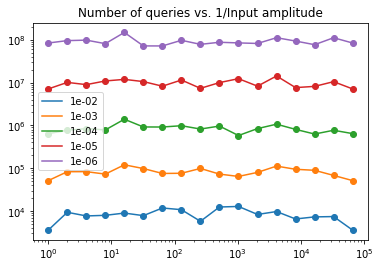

In [7]:
for i in range(len(epsilons)):
    plt.plot(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])
    plt.scatter(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])

plt.title('Number of queries vs. 1/Input amplitude')
plt.legend(['{:.0e}'.format(eps) for eps in epsilons])
plt.xscale('log')
plt.yscale('log')

plt.show()